# More about volatility

## Volatility: number of sites

Here we need to go back to number of sites selection as in "construct training data" section in part 1. Let's pull up all information and data we need.

In [50]:
#In this section, we will do 08641 only
#specify data source, zipcode (along with latitude, longitue, and timezone), and bin values to calculate mean.
datasource = 'L'
[zipcode, latitude, longitude, localtz] = ['08641', 40.0449, -74.5892, 'US/Eastern']
#this vin values serves only NJ 
binvalue = [0.60000000000000009, 1.5531428571428569, 2.5209606741573034, 4.1015736906211933, 7.487476098503139, 12.943637931034482]

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz
import os
import patsy #for spline regression
import scipy #for non-negative least square 
import scipy as sp 
from scipy import stats
from scipy.optimize import nnls
from numpy.linalg import inv #for matrix and statistics
import scipy as sp
import math
import statsmodels.api as sm
import random
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import sklearn.cluster
import sklearn.linear_model
%matplotlib inline

In [52]:
#mainDir = 'C:/Users/Tee/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis'
#read data and metadata
metadata = pd.read_csv(mainDir+ '/data/solar/' + datasource +'/' + zipcode +'/metadata.csv',
                             dtype={'componentId':'object','zip':'object'})
data = pd.read_csv(mainDir+ '/data/solar/' + datasource +'/'+ zipcode+'/data.csv',
                             dtype={'componentId':'object'})
#convert timestamp string to datetime format if needed
#metadata['FirstTimestamp'] = metadata['FirstTimestamp'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
data['tsLocal'] = data['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

In [53]:
dataDir = mainDir + '/data/solar/' + datasource +'/' + zipcode +'/'
#reference for maximum power curves
data_ref = pd.read_csv(dataDir +'/training_data_fitted_adjusted.csv')
data_ref['tsLocal'] = data_ref['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

In [54]:
#size assignment according to buckets
metadata['size'] = float('NaN')
metadata.loc[metadata.sizeBucket == '0-1 kW','size'] = binvalue[0]
metadata.loc[metadata.sizeBucket == '1-2 kW','size'] = binvalue[1]
metadata.loc[metadata.sizeBucket == '2-3 kW','size'] = binvalue[2]
metadata.loc[metadata.sizeBucket == '3-5 kW','size'] = binvalue[3]
metadata.loc[metadata.sizeBucket == '5-10 kW','size'] = binvalue[4]
metadata.loc[metadata.sizeBucket == '10-20 kW','size'] = binvalue[5]

In [55]:
#select only residential components
metadata = metadata[metadata['size'] <= 20]
data = data[['tsLocal','altitude','azimuth']+list(metadata['componentId'])]

## Basic time series construction

In [56]:
#specify scope
StartScopeDate = '2014-01-01'
EndScopeDate = '2015-01-01'
StartScopeTime =  datetime.datetime.strptime(StartScopeDate,"%Y-%m-%d")
EndScopeTime =  datetime.datetime.strptime(EndScopeDate,"%Y-%m-%d")

#Generate data frame from start to end for time series
tslist = []
nxt = StartScopeTime
while nxt < EndScopeTime:
    tslist.append(nxt)
    nxt += datetime.timedelta(minutes=15)
    
Scope = pd.DataFrame(0, index = np.arange(len(tslist)), columns = ['tsLocal'])
Scope['tsLocal'] = tslist

#Now we can merge using Scope Table as a backbone of data structure.
d = pd.merge(Scope,data,on=['tsLocal'], how = 'left') 

In [58]:
data = d
data = data.set_index(['tsLocal','altitude','azimuth'])

In [59]:
d = pd.merge(Scope,data_ref,on=['tsLocal'], how = 'left') 
data_ref = d
data_ref.set_index(['tsLocal'],inplace=True)

Choose specific number of components in calculation

In [74]:
#select data for training and test
numlist = [10,20,40,80,160]
VariabilityGrand = pd.DataFrame()

In [63]:
data.shape, metadata.shape, data_ref.shape

((35040, 241), (241, 8), (35040, 11))

Since we are not building maximum power profile for all models, we will use status-quo persistent volatility with maximum power curve from a reference.

In [75]:
for num in numlist: 
    dat = data.loc[:,data.columns[0:num]]
    presencecheck = dat.notnull()
    
    dat['numactivecomp'] = presencecheck.sum(axis=1)
    dat['totalpower'] = dat.sum(axis=1)
    for i in presencecheck.columns.values:
        presencecheck[i] = presencecheck[i]*metadata[metadata.componentId == i]['size'].iloc[0]
    dat['totalsize'] = presencecheck.sum(axis=1)
    dat['power'] = dat['totalpower']/dat['totalsize']
    #dat['power'][dat.numactivecomp<50] = float('NaN')
    dat.reset_index(inplace=True)
    
    d = dat[['tsLocal','altitude','azimuth','power','numactivecomp','totalsize']]
    
    TestData = d
    TestData.set_index(['tsLocal'],inplace=True)
    TestDateList = list(set(TestData.index.map(lambda x: x.date())))
    #set up date list and summary table
    TestDateList.sort()
    VariabilityTable = pd.DataFrame()
    VariabilityTable['Date']=TestDateList
    
    for i in range(0,VariabilityTable.shape[0]):
        DailyData = TestData[TestData.index.map(lambda x: x.date()) == VariabilityTable.Date[i]]
        DailyData_ref = data_ref[data_ref.index.map(lambda x: x.date()) == VariabilityTable.Date[i]]
        DailyData['mpower'] = DailyData_ref['mpower']
        d_series = DailyData[['power','mpower']].dropna()
        d_series = d_series.reset_index(drop=True)

        #without shift
        l = d_series.loc[range(1,d_series.shape[0]),'power'].reset_index(drop=True)- \
                d_series.loc[range(0,d_series.shape[0]-1),'power']/d_series.loc[range(0,d_series.shape[0]-1),'mpower']* \
                d_series.loc[range(1,d_series.shape[0]),'mpower'].reset_index(drop=True)
        VariabilityTable.loc[i,'V_s'] = np.sum(np.absolute(l))
        
    VariabilityGrand = pd.concat([VariabilityGrand,VariabilityTable.set_index('Date')],axis = 1)
    
    #run another batch
    dat = data.loc[:,data.columns[num:(2*num)]]
    presencecheck = dat.notnull()
    
    dat['numactivecomp'] = presencecheck.sum(axis=1)
    dat['totalpower'] = dat.sum(axis=1)
    for i in presencecheck.columns.values:
        presencecheck[i] = presencecheck[i]*metadata[metadata.componentId == i]['size'].iloc[0]
    dat['totalsize'] = presencecheck.sum(axis=1)
    dat['power'] = dat['totalpower']/dat['totalsize']
    #dat['power'][dat.numactivecomp<50] = float('NaN')
    dat.reset_index(inplace=True)
    
    d = dat[['tsLocal','altitude','azimuth','power','numactivecomp','totalsize']]
    
    TestData = d
    TestData.set_index(['tsLocal'],inplace=True)
    TestDateList = list(set(TestData.index.map(lambda x: x.date())))
    #set up date list and summary table
    TestDateList.sort()
    VariabilityTable = pd.DataFrame()
    VariabilityTable['Date']=TestDateList
    
    for i in range(0,VariabilityTable.shape[0]):
        DailyData = TestData[TestData.index.map(lambda x: x.date()) == VariabilityTable.Date[i]]
        DailyData_ref = data_ref[data_ref.index.map(lambda x: x.date()) == VariabilityTable.Date[i]]
        DailyData['mpower'] = DailyData_ref['mpower']
        d_series = DailyData[['power','mpower']].dropna()
        d_series = d_series.reset_index(drop=True)

        #without shift
        l = d_series.loc[range(1,d_series.shape[0]),'power'].reset_index(drop=True)- \
                d_series.loc[range(0,d_series.shape[0]-1),'power']/d_series.loc[range(0,d_series.shape[0]-1),'mpower']* \
                d_series.loc[range(1,d_series.shape[0]),'mpower'].reset_index(drop=True)
        VariabilityTable.loc[i,'V_s'] = np.sum(np.absolute(l))
        
    VariabilityGrand = pd.concat([VariabilityGrand,VariabilityTable.set_index('Date')],axis = 1)

C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Admin\Anaconda\lib\site-packages\IPython\kernel\__main__.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [78]:
VariabilityGrand.columns = ['A-1', 'A-2','B-1', 'B-2','C-1', 'C-2','D-1', 'D-2','E-1', 'E-2']

In [86]:
#VariabilityGrand

It is clear that as $V(S_1\cup S_2) < max(V(S_1),V(S_2))$. Moreover, $V(S_1\cup S_2) \le (V(S_1)+V(S_2))/2$ as we expected. It is worth to note that $V$ is stable (within 0.01 accuracy) when the number of sites is larger than 160.

In [82]:
#mean and std by column
mean_V = [0]*10
std_V = [0]*10
for i in range(0,10):
    mean_V[i] = np.mean(VariabilityGrand.loc[:,VariabilityGrand.columns[i]])
    std_V[i] = np.mean(VariabilityGrand.loc[:,VariabilityGrand.columns[i]])

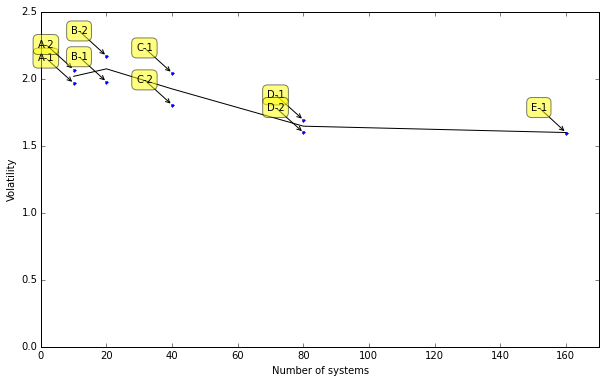

In [92]:
l = mean_V
m = [l[0]/2+l[1]/2,l[2]/2+l[3]/2,l[4]/2+l[5]/2,l[6]/2+l[7]/2,l[8]]
fig = plt.figure(figsize=(10, 6))

ax1  = fig.add_subplot(111)

X = [10,10,20,20,40,40,80,80,160]
Y = l[0:9]
labels = ['A-1', 'A-2','B-1', 'B-2','C-1', 'C-2','D-1', 'D-2','E-1']
ax1.plot(X,Y,'.')
for label, x, y in zip(labels, X, Y):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

ax1.plot([10,20,40,80,160],m,color='black')
ax1.set_xlim(0,170)
ax1.set_ylim(0,2.5)
ax1.set_xlabel('Number of systems')
ax1.set_ylabel('Volatility')



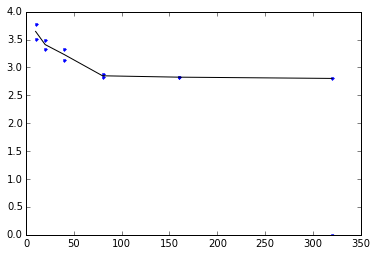

In [42]:
#example of low daily volatility 
l = VariabilityGrand.loc[datetime.date(2014,12,5),:]
m = [l[0]/2+l[1]/2,l[2]/2+l[3]/2,l[4]/2+l[5]/2,l[6]/2+l[7]/2,l[8]/2+l[9]/2,l[10]]
fig = plt.figure(figsize=(6, 4))
plt.plot([10,10,20,20,40,40,80,80,160,160,320,320],l,'.')
plt.plot([10,20,40,80,160,320],m,color='black')

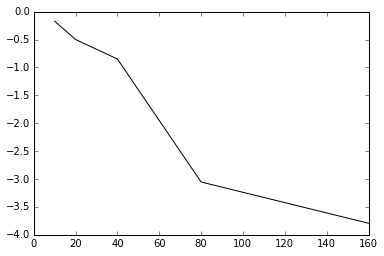

In [43]:
#example of low daily volatility 
l = VariabilityGrand.loc[datetime.date(2014,12,5),:]
m = [l[0]/2+l[1]/2,l[2]/2+l[3]/2,l[4]/2+l[5]/2,l[6]/2+l[7]/2,l[8]/2+l[9]/2]
fig = plt.figure(figsize=(6, 4))
#plt.plot([10,10,20,20,40,40,80,80,160,160,320,320],l-l[10],'.')
plt.plot([10,20,40,80,160],np.log(m-l[10]),color='black')

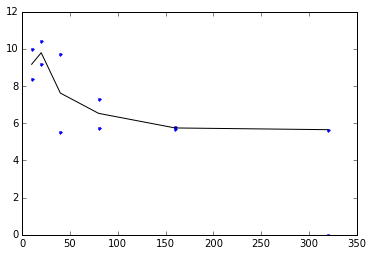

In [44]:
#example of medium daily volatility 
l = VariabilityGrand.loc[datetime.date(2014,12,30),:]
m = [l[0]/2+l[1]/2,l[2]/2+l[3]/2,l[4]/2+l[5]/2,l[6]/2+l[7]/2,l[8]/2+l[9]/2,l[10]]
fig = plt.figure(figsize=(6, 4))
plt.plot([10,10,20,20,40,40,80,80,160,160,320,320],l,'.')
plt.plot([10,20,40,80,160,320],m,color='black')

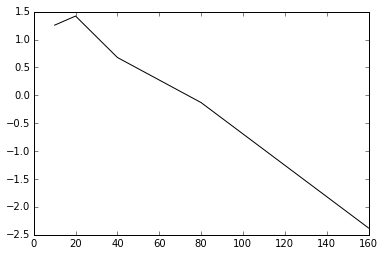

In [45]:
#example of medium daily volatility 
l = VariabilityGrand.loc[datetime.date(2014,12,30),:]
m = [l[0]/2+l[1]/2,l[2]/2+l[3]/2,l[4]/2+l[5]/2,l[6]/2+l[7]/2,l[8]/2+l[9]/2]
fig = plt.figure(figsize=(6, 4))
#plt.plot([10,10,20,20,40,40,80,80,160,160,320,320],l-l[10],'.')
plt.plot([10,20,40,80,160],np.log(m-l[10]),color='black')

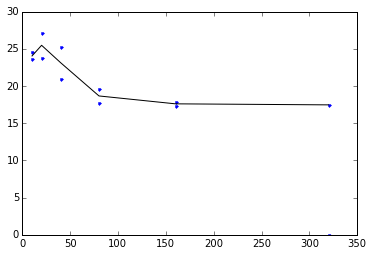

In [46]:
#example of high daily volatility 
l = VariabilityGrand.loc[datetime.date(2014,10,18),:]
m = [l[0]/2+l[1]/2,l[2]/2+l[3]/2,l[4]/2+l[5]/2,l[6]/2+l[7]/2,l[8]/2+l[9]/2,l[10]]
fig = plt.figure(figsize=(6, 4))
plt.plot([10,10,20,20,40,40,80,80,160,160,320,320],l,'.')
plt.plot([10,20,40,80,160,320],m,color='black')

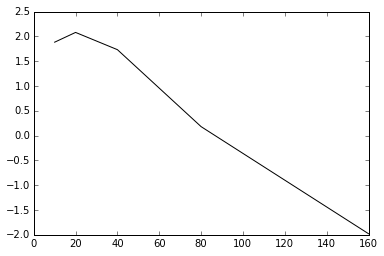

In [47]:
#example of high daily volatility 
l = VariabilityGrand.loc[datetime.date(2014,10,18),:]
m = [l[0]/2+l[1]/2,l[2]/2+l[3]/2,l[4]/2+l[5]/2,l[6]/2+l[7]/2,l[8]/2+l[9]/2]
fig = plt.figure(figsize=(6, 4))
#plt.plot([10,10,20,20,40,40,80,80,160,160,320,320],l-l[10],'.')
plt.plot([10,20,40,80,160],np.log(m-l[10]),color='black')
#plt.plot([10,20,40,80],np.log(m[0:4]-l[10]),color='black')

In [48]:
#systematic calculation of drop-down rate
VariabilityGrand['droprate']=float('NaN')


In [49]:
i=0
l = VariabilityGrand.loc[VariabilityGrand.index[i],:]
m = [l[0]/2+l[1]/2,l[2]/2+l[3]/2,l[4]/2+l[5]/2,l[6]/2+l[7]/2,l[8]/2+l[9]/2]
x = np.c_[10,20,40,80,160].T
y = np.log(m-l[10])
#plt.plot(x,y)
mod = sklearn.linear_model.LinearRegression(fit_intercept=True).fit(x,y)
mod.coef_


array([-0.01827059])

In [50]:
y[3]

-0.73405742290096354

In [51]:
for i in range(0,VariabilityGrand.shape[0]):
    l = VariabilityGrand.loc[VariabilityGrand.index[i],:]
    m = [l[0]/2+l[1]/2,l[2]/2+l[3]/2,l[4]/2+l[5]/2,l[6]/2+l[7]/2,l[8]/2+l[9]/2]
    x = np.c_[10,20,40,80,160].T
    y = np.log(m-l[10])
    #plt.plot(x,y)
    if not np.isnan(y).any():
        mod = sklearn.linear_model.LinearRegression(fit_intercept=True).fit(x,y)
        VariabilityGrand.loc[VariabilityGrand.index[i],'droprate'] = mod.coef_

(array([  1.,   1.,   0.,   1.,   4.,  13.,  10.,  12.,   4.,   1.]),
 array([ -5.44809968e-02,  -4.90423354e-02,  -4.36036739e-02,
         -3.81650124e-02,  -3.27263510e-02,  -2.72876895e-02,
         -2.18490280e-02,  -1.64103666e-02,  -1.09717051e-02,
         -5.53304366e-03,  -9.43821974e-05]),
 <a list of 10 Patch objects>)

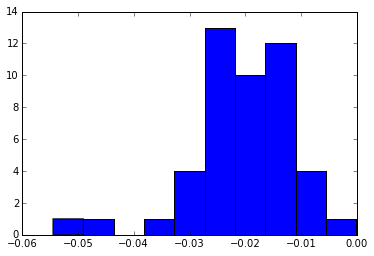

In [52]:
plt.hist(VariabilityGrand['droprate'].dropna())

In [53]:
np.mean(VariabilityGrand['droprate'].dropna()),np.median(VariabilityGrand['droprate'].dropna())

(-0.020385568539642195, -0.019524303199193679)

In conclusion, the volatility drops to a limit with exponential rate with consistent decay constant about 0.02.